In [1]:
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split

c:\Users\wlf04\anaconda3\envs\tf\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\wlf04\anaconda3\envs\tf\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.11.0 and strictly below 2.14.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want

## Load pre-trained AutoEncoder models 

In [2]:
# Define the custom objects with their corresponding classes
custom_objects = {
    'RectifiedAdam': tfa.optimizers.RectifiedAdam
}

In [ ]:
# Load the models with the custom optimizer
model_1 = tf.keras.models.load_model('./AutoEncoder_original_epoch50/', custom_objects=custom_objects)
# model_2 = tf.keras.models.load_model('./AutoEncoder/', custom_objects=custom_objects)

## Load datasets

In [3]:
# Path to the saved preprocessed non-damage images
output_non_damage_path = './non_damage_preprocessed.npy'
# Path to the saved preprocessed damage images
output_damage_path = './damage_preprocessed.npy'

# Load the preprocessed non-damage images
non_damage_images = np.load(output_non_damage_path)
print("Non-damage images loaded. Shape:", non_damage_images.shape)

# Load the preprocessed damage images
damage_images = np.load(output_damage_path)
print("Damage images loaded. Shape:", damage_images.shape)

Non-damage images loaded. Shape: (6472, 128, 128, 1)
Damage images loaded. Shape: (7317, 128, 128, 1)


## Get Classification Model by adding classification layers

In [6]:
def get_classification_model(pretrained_model):
    # Use the output of the last encoder layer
    # Based on the summary of model_1
    # conv2d_15 is the last convolutional layer before the transpose convolution layers (conv2d_transpose)
    encoder_output = pretrained_model.get_layer('conv2d_15').output

    # Flatten the output of the encoder
    flat = Flatten()(encoder_output)

    # Add classification layers
    classifier_layer = Dense(128, activation='relu')(flat)
    classifier_output = Dense(2, activation='softmax')(classifier_layer)

    # Create the classification model
    classifier_model = Model(inputs=pretrained_model.input, outputs=classifier_output)

    # Compile the model
    classifier_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return classifier_model

# Load your pre-trained model
# model_1 = tf.keras.models.load_model('./AutoEncoder_original_epoch50/', custom_objects={'RectifiedAdam': tfa.optimizers.RectifiedAdam})

# Create the classification model
model = get_classification_model(model_1)

In [4]:
# Prepare your dataset
X = np.concatenate((non_damage_images, damage_images), axis=0)
y = np.array([0] * len(non_damage_images) + [1] * len(damage_images))

SEED = 42

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

In [ ]:
# Train the classifier
model.fit(X_train, y_train, epochs=10, batch_size=8)

# Evaluate the classifier
performance = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {performance[1]}')

In [11]:
# save classifier model
model.save('Classifier_model_1')

INFO:tensorflow:Assets written to: Classifier_model_1\assets


INFO:tensorflow:Assets written to: Classifier_model_1\assets


## Visulization of result

### Confusion Matrix

In [5]:
model = tf.keras.models.load_model('./Classifier_model_1/', custom_objects=custom_objects)

In [6]:
# with tf.device('/cpu:0'):
y_pred = model.predict(X_test, batch_size=8)
y_pred_classes = np.argmax(y_pred, axis=1)

345/345 [==============================] - 48s 118ms/step


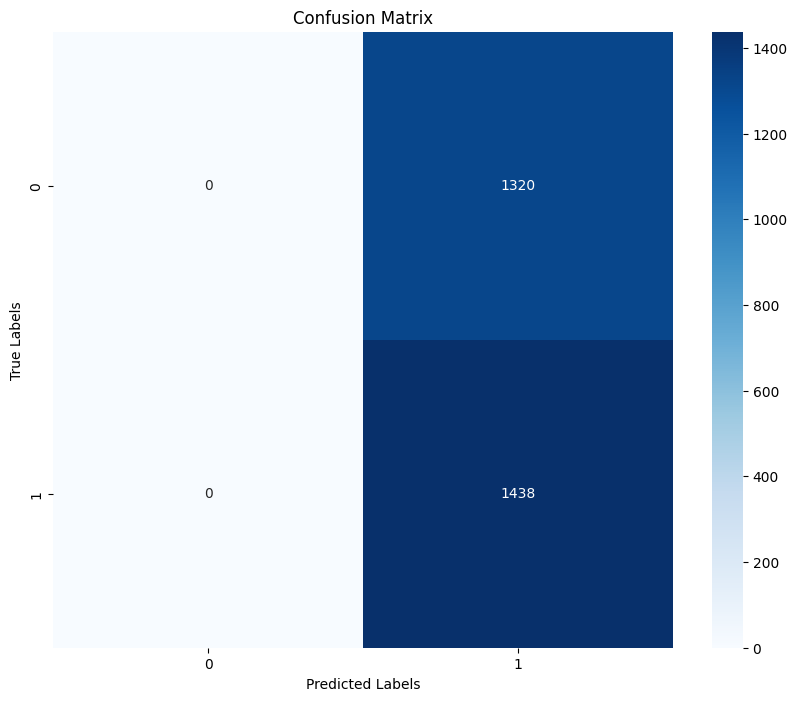

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Predict classes for the test set
# y_pred = model.predict(X_test)
# y_pred_classes = np.argmax(y_pred, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


### Sample Predictions

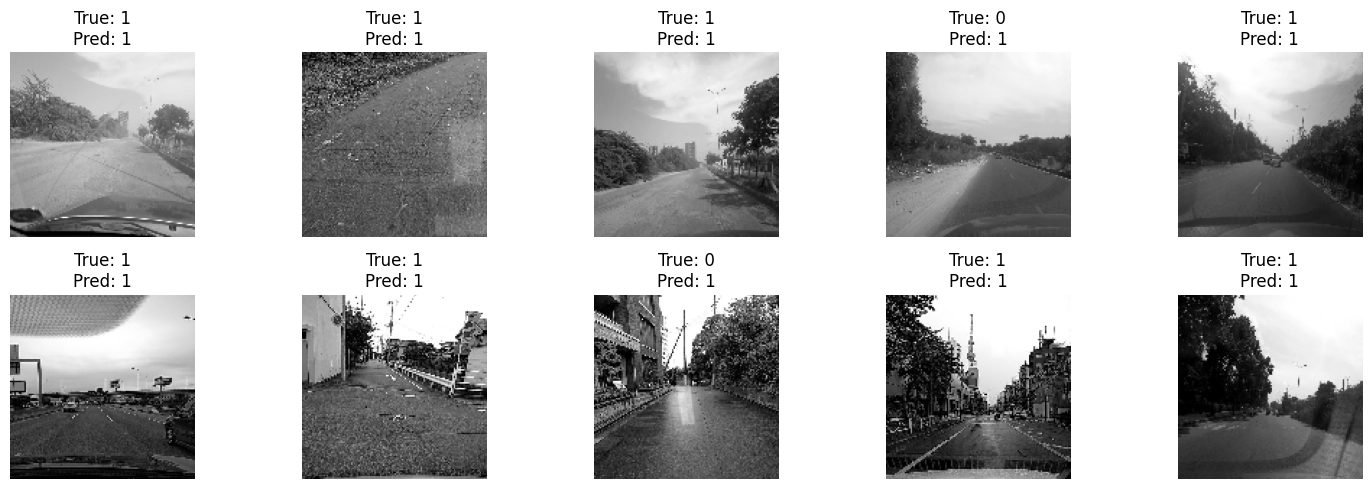

In [17]:
# Function to display images along with their true and predicted labels
def display_sample_predictions(images, true_labels, predicted_labels, num_images=10):
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(2, num_images//2, i+1)
        plt.imshow(images[i].reshape(128, 128), cmap='gray')
        plt.title(f"True: {true_labels[i]}\nPred: {predicted_labels[i]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Display sample predictions
num_samples = 10  # Number of samples you want to display
indices = np.random.choice(range(len(X_test)), num_samples, replace=False)
sample_images = X_test[indices]
sample_true_labels = y_test[indices]
sample_pred_labels = y_pred_classes[indices]

display_sample_predictions(sample_images, sample_true_labels, sample_pred_labels, num_images=num_samples)


In [8]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# You should already have y_pred_classes from your model's predictions
# y_test contains the true labels

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes, average='binary')
recall = recall_score(y_test, y_pred_classes, average='binary')
f1 = f1_score(y_test, y_pred_classes, average='binary')

# Print the metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Accuracy: 0.5213923132704859
Precision: 0.5213923132704859
Recall: 1.0
F1 Score: 0.6854146806482364


Confusion Matrix result does not make sense, try to fix it

## Handle class imbalance

In [9]:
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights which can be used in training the model
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weights_dict = {i : class_weights[i] for i in range(len(class_weights))}
print(class_weights_dict)


{0: 1.0705551242236024, 1: 0.938169756761354}


dataset has a slight imbalance: 

class 0 is less frequent than class 1. 

The weights are calculated to inversely compensate for the class frequencies, 

meaning the model will put more emphasis on correctly predicting instances of the less frequent class (class 0) during training.

In [11]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Create early stopping (stop training after the validation loss has not improved for 5 epochs)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

# Reduce learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    verbose=1,
    min_lr=1e-6
)

# Decrease the batch size to manage GPU memory
batch_size = 8

# Train the model
history = model.fit(
    X_train, y_train,
    validation_split=0.2,  # Use part of the training set for validation
    epochs=50,  # Start with a reasonable number and rely on early stopping
    batch_size=batch_size,
    class_weight=class_weights_dict,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/50
1103/1103 [==============================] - 496s 377ms/step - loss: 0.6934 - accuracy: 0.5279 - val_loss: 0.6946 - val_accuracy: 0.4685 - lr: 0.0010
Epoch 2/50
1103/1103 [==============================] - 413s 374ms/step - loss: 0.6933 - accuracy: 0.5025 - val_loss: 0.6931 - val_accuracy: 0.5315 - lr: 0.0010
Epoch 3/50
1103/1103 [==============================] - 413s 374ms/step - loss: 0.6932 - accuracy: 0.5082 - val_loss: 0.6939 - val_accuracy: 0.4685 - lr: 0.0010
Epoch 4/50
1103/1103 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.5138
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
1103/1103 [==============================] - 412s 374ms/step - loss: 0.6931 - accuracy: 0.5138 - val_loss: 0.6950 - val_accuracy: 0.4685 - lr: 0.0010
Epoch 5/50
1103/1103 [==============================] - 413s 374ms/step - loss: 0.6933 - accuracy: 0.4667 - val_loss: 0.6940 - val_accuracy: 0.4685 - lr: 2.0000e-04
Epoch 6/50
1103/1103 [=====

In [12]:
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 512)     5120      
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 512)     2359808   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 512)      0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 256)       1179904   
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 256)       590080    
                                                             

345/345 [==============================] - 37s 107ms/step


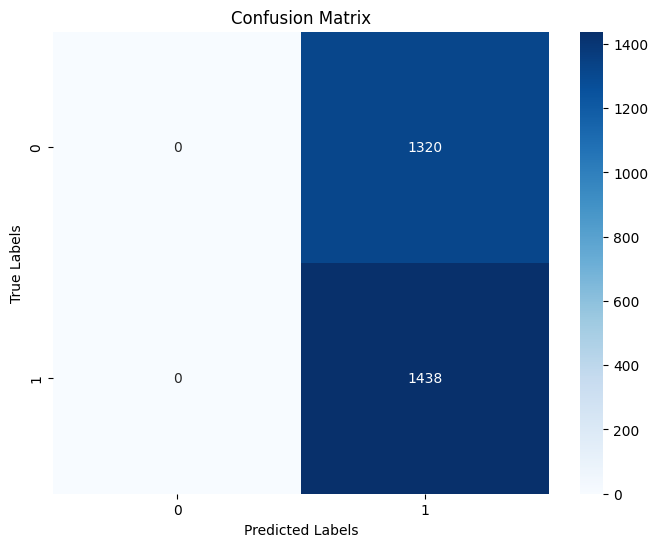

Accuracy: 0.5213923132704859
Precision: 0.5213923132704859
Recall: 1.0
F1 Score: 0.6854146806482364


In [13]:
# Predict the classes on the test set
y_pred_probs = model.predict(X_test, batch_size=batch_size)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Calculate accuracy and other metrics
accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes)
f1 = f1_score(y_test, y_pred_classes)

# Print the metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
